#### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 불균형 데이터 분류

이 튜토리얼에서는 한 클래스의 예시의 수가 다른 클래스보다 훨씬 많은 불균형 데이터세트를 분류하는 방법을 소개합니다. Kaggle에서 호스팅 되는 [신용 카드 부정 행위 탐지 데이터세트](https://www.kaggle.com/mlg-ulb/creditcardfraud)를 사용하여 작업할 것입니다. 총 284,807건의 거래에서 492건의 부정거래만 적발하는 것이 목적입니다. [Keras](../../guide/keras/overview.ipynb)를 사용하여 모델 및 [클래스 가중치](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model)를 정의하여 불균형 데이터로부터 모델을 학습할 수 있도록 할 것입니다.

이 튜토리얼에서는 다음의 완전한 코드가 포함되어있습니다.:

* Pandas를 사용하여 CSV 파일 로드.
* 학습, 검증 및 테스트세트 작성.
* Keras를 사용하여 모델을 정의하고 학습시키기(클래스 가중치 설정 포함).
* 다양한 측정 기준(정밀도 및 재현 율 포함)을 사용하여 모델을 평가한다.
* 불균형 데이터를 처리하기 위한 다음과 같은 기술을 사용해보십시오:
    * 클래스 가중치 
    * 오버샘플링


## 설정

In [30]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [95]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### 데이터 불러오기 및 불균형 정도 확인

In [45]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [46]:
print(train['FDS_CATH'].value_counts()/len(train))
print(test['FDS_CATH'].value_counts()/len(test))

0    0.97118
1    0.02882
Name: FDS_CATH, dtype: float64
0    0.985488
1    0.014512
Name: FDS_CATH, dtype: float64


In [47]:
train=train.drop('FRST_RCV_DT', axis=1)
test=test.drop('FRST_RCV_DT', axis=1)

In [48]:
train.head()

,ACDNT_CLAS_CD2,CAR_TYPE_NM,INSR_TYPE_NM,NON_FALT_CLAS_CD,INDM_EXPC_CD,OAI_FALT_RATE_G,CURE_YN,LBS_START,FRAUD_DOUBT_CD,DISPATCH_TOWING,...,NO_LICENSE,DRUNK_YN,LICNS_TYPE_CD,DRIVER_VOCTN_TST_GAP_G,LIC_2MOTO,DRIVER_LICNS_STAT,LICNS_CANCEL_YN,DRIVER_INFO_AGREE,ACDNT_TOTAL_TEXT_1,FDS_CATH
0,G1,ME,PAP,G1,G1,G6,G1,G2,G2,G3,...,N,N,G5,G0,G1,G1,N,G3,NN,0
1,G2,RV,PAP,G1,G0,G1,G1,G1,G2,G3,...,N,N,G5,G0,G3,G3,N,G1,NN,0
2,G2,ME,PAP,G1,G1,G6,G1,G2,G2,G4,...,N,Y,G2,G0,G1,G1,N,G3,NY,0
3,G1,PO,BAP,G1,G1,G4,G1,G2,G2,G3,...,N,N,G2,G3,G1,G1,N,G3,NN,0
4,G2,ME,PAP,G1,G1,G1,G1,G1,G2,G4,...,N,N,G5,G0,G3,G3,N,G1,NN,0


In [60]:
train['CAR_TYPE_NM'].dtype

dtype('O')

In [61]:
def labelencoding(data):
    le = LabelEncoder()
    for column in data.columns:
        if data[column].dtype == 'O':
            data[column]=le.fit_transform(data[column])
        else : pass

In [62]:
labelencoding(train)

In [63]:
labelencoding(test)

In [64]:
train.head()

,ACDNT_CLAS_CD2,CAR_TYPE_NM,INSR_TYPE_NM,NON_FALT_CLAS_CD,INDM_EXPC_CD,OAI_FALT_RATE_G,CURE_YN,LBS_START,FRAUD_DOUBT_CD,DISPATCH_TOWING,...,NO_LICENSE,DRUNK_YN,LICNS_TYPE_CD,DRIVER_VOCTN_TST_GAP_G,LIC_2MOTO,DRIVER_LICNS_STAT,LICNS_CANCEL_YN,DRIVER_INFO_AGREE,ACDNT_TOTAL_TEXT_1,FDS_CATH
0,0,3,3,0,1,6,0,1,1,2,...,0,0,3,0,0,0,0,1,0,0
1,1,5,3,0,0,1,0,0,1,2,...,0,0,3,0,2,2,0,0,0,0
2,1,3,3,0,1,6,0,1,1,3,...,0,1,1,0,0,0,0,1,1,0
3,0,4,0,0,1,4,0,1,1,2,...,0,0,1,3,0,0,0,1,0,0
4,1,3,3,0,1,1,0,0,1,3,...,0,0,3,0,2,2,0,0,0,0


In [65]:
test.head()

,ACDNT_CLAS_CD2,CAR_TYPE_NM,INSR_TYPE_NM,NON_FALT_CLAS_CD,INDM_EXPC_CD,OAI_FALT_RATE_G,CURE_YN,LBS_START,FRAUD_DOUBT_CD,DISPATCH_TOWING,...,NO_LICENSE,DRUNK_YN,LICNS_TYPE_CD,DRIVER_VOCTN_TST_GAP_G,LIC_2MOTO,DRIVER_LICNS_STAT,LICNS_CANCEL_YN,DRIVER_INFO_AGREE,ACDNT_TOTAL_TEXT_1,FDS_CATH
0,2,3,0,0,1,6,1,1,1,3,...,0,0,1,0,0,0,0,1,1,0
1,0,4,3,0,1,6,1,1,1,3,...,0,0,1,6,0,0,0,1,1,0
2,0,1,3,0,1,6,0,1,1,3,...,0,0,1,0,1,0,0,1,0,0
3,1,4,3,0,1,2,1,1,1,3,...,0,0,1,0,0,0,0,1,0,0
4,1,3,0,0,1,6,0,0,1,3,...,1,0,1,0,0,1,1,1,1,1


### 데이터 정리, 분할 및 정규화


데이터 세트를 학습, 검증 및 테스트 세트로 분할합니다. 검증 세트는 모델 피팅 중에 손실 및 메트릭을 평가하는 데 사용되지만 모델이 이 데이터에 적합하지 않습니다. 테스트 세트는 훈련 단계에서 완전히 사용되지 않으며 모델이 새 데이터로 얼마나 잘 일반화되는지 평가하기 위해 마지막에만 사용됩니다. 이는 훈련 데이터 부족으로 인하여 [오버피팅](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) 이 중요한 문제인 데이터 세트에서 특히 더 중요합니다.

정규화를 시켜야하나?

In [67]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, val_df = train_test_split(train, test_size=0.2)
test_df =test

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('FDS_CATH'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('FDS_CATH'))
test_labels = np.array(test_df.pop('FDS_CATH'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

sklearn StandardScaler를 사용하여 입력 기능을 정규화 합니다.
이것은 평균은 0으로, 표준 편차는 1로 설정합니다.

참고: StandardScaler는 오직 모델이 validation 또는 test set를 peeking 하지는 않았는지 확인하기 위해 train_feature를 사용할 때 적합합니다. 

In [69]:
#여기선 하지 않는다
#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)

#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (102679,)
Validation labels shape: (25670,)
Test labels shape: (8200,)
Training features shape: (102679, 20)
Validation features shape: (25670, 20)
Test features shape: (8200, 20)


In [70]:
bool_train_labels

array([False, False, False, ..., False, False, False])

주의: 모델을 배포하려면 전처리 계산을 유지하는 것이 중요합니다. 레이어로 구현하고 내보내기 전에 모델에 연결하는 것이 가장 쉬운 방법입니다.


### 데이터 분포 살펴보기 

다음으로 몇 가지 기능에 대한 긍정 및 부정 예제의 분포를 비교하십시오. 이 때 스스로에게 물어볼 좋은 질문은 다음과 같습니다.:

* 이러한 분포가 의미가 있습니까?
    * 예. 이미 입력을 정규화했으며 대부분 `+/- 2` 범위에 밀집되어 있습니다.
* 분포의 차이를 볼 수 있습니까?
    * 예. 긍정적인 예는 그렇지 않은 것 보다 훨씬 더 높은 극단적인 값을 포함합니다.

In [72]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

In [73]:
pos_df

,ACDNT_CLAS_CD2,CAR_TYPE_NM,INSR_TYPE_NM,NON_FALT_CLAS_CD,INDM_EXPC_CD,OAI_FALT_RATE_G,CURE_YN,LBS_START,FRAUD_DOUBT_CD,DISPATCH_TOWING,DRUNK_A,NO_LICENSE,DRUNK_YN,LICNS_TYPE_CD,DRIVER_VOCTN_TST_GAP_G,LIC_2MOTO,DRIVER_LICNS_STAT,LICNS_CANCEL_YN,DRIVER_INFO_AGREE,ACDNT_TOTAL_TEXT_1
0,1,7,3,0,1,6,0,1,1,3,0,0,0,1,0,0,0,0,1,0
1,3,4,0,0,1,6,0,1,1,3,0,1,0,1,0,2,2,0,1,2
2,0,6,3,0,1,6,0,1,1,2,0,0,0,3,0,0,0,0,1,1
3,1,5,3,0,1,6,0,1,1,3,0,0,0,1,0,0,0,0,0,0
4,1,3,3,2,1,1,1,0,1,2,0,0,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,2,6,3,0,1,6,1,0,1,3,0,0,0,1,0,0,0,0,1,3
2973,3,3,3,0,1,6,0,1,1,3,0,1,0,3,0,0,1,1,1,0
2974,0,7,3,0,1,5,0,1,1,3,0,0,0,1,0,0,0,0,1,0
2975,0,6,3,0,1,6,0,1,0,2,0,1,0,3,0,0,1,1,1,1


In [74]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

#sns.jointplot(pos_df['V5'], pos_df['V6'],
              #kind='hex', xlim=(-5,5), ylim=(-5,5))
#plt.suptitle("Positive distribution")

#sns.jointplot(neg_df['V5'], neg_df['V6'],
              #kind='hex', xlim=(-5,5), ylim=(-5,5))
#_ = plt.suptitle("Negative distribution")

## 모델 및 메트릭 정의

촘촘하게 연결된 히든 레이어, 과적합을 줄이기 위한 [drop out](https://developers.google.com/machine-learning/glossary/#dropout_regularization) 레이어, 거래 사기 가능성을 반환하는 출력 sigmoid 레이어로 간단한 신경망을 생성하는 함수를 정의합니다. : 

In [75]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

### 유용한 메트릭 이해

위에서 정의한 몇 가지 지표는 성능을 평가할 때 도움이 될 모델에 의해 계산될 수 있다는 점에 유의하십시오. 



*   **거짓** 음성 그리고 **거짓** 양성은 **잘못** 분류된 샘플입니다.
*   **참** 음성 그리고 **참** 양성은 **제대로** 분류된 샘플입니다.
*   **정확도** 는 올바르게 분류된 예제의 비율입니다.
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **정밀도** 는 올바르게 분류된 **예측** 긍정 비율입니다.
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **재현 율** 은 올바르게 분류된 **실제** 긍정 비율입니다.
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** 는 수신자 조작 특성 곡선 아래 영역(ROC-AUC)을 나타냅니다. 이 메트릭은 분류기가 무작위 음성 샘플보다 무작위 양성 샘플의 순위를 매길 확률과 동일합니다. 

참고: 정확도는 이 작업에 유용한 측정 항목이 아닙니다. 항상 False를 예측해야 이 작업에서 99.8% 이상의 정확도를 얻을 수 있습니다.  

Read more:
*  [참 vs. 거짓 and 긍정 vs. 부정](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [정확성](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [정밀도와 재현율](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

## 기준 모델

### 모델 구축

이제 이전에 정의한 함수를 통해서 모델을 만들고 학습시키십시오. 모델의 크기가 기본 배치 크기인 2048보다 큰 배치 크기를 사용하여야 적합한 것을 유의하십시오. 이는 각 배치에서 몇 개의 양성 샘플을 포함할 수 있는 적절한 기회를 확보하는데 있어서 중요하다. 


참고: 이 모델은 클래스의 불균형을 잘 다루지 못합니다. 이를 이 튜토리얼의 뒷부분에서 개선하게 될 겁니다.

In [76]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [77]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [78]:
model.predict(train_features[:10])

array([[0.3927616 ],
       [0.6651877 ],
       [0.44917738],
       [0.47580206],
       [0.38233536],
       [0.56602395],
       [0.51027787],
       [0.74186337],
       [0.5625686 ],
       [0.5516651 ]], dtype=float32)

### 선택사항: 올바른 초기 바이어스를 설정합니다.

이러한 초기 추측은 좋지 못합니다. 데이터 세트가 불균형 하다는 것을 알고 있습니다. 그렇다면 이를 반영하도록 출력 계층의 바이어스를 설정합니다. (참조: [신경망 훈련을 위한 레시피: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). 이것은 초기 수렴에 도움이 될 수 있습니다. 

기본 바이어스 초기화를 사용하면 손실은 약 `math.log(2) = 0.69314` 

In [79]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.8827


In [81]:
neg, pos = np.bincount(bool_train_labels)
total = neg+pos

In [82]:
pos

2977

In [83]:
neg

99702

설정할 올바른 바이어스는 다음에서 파생 가능합니다.:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [84]:
initial_bias = np.log([pos/neg])
initial_bias

array([-3.51126965])

이를 초기 바이어스로 설정하면 모델이 훨씬 더 합리적인 초기 추측을 제공합니다. 

가까워 야합니다.: `pos/total = 0.0018`

In [85]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.11911696],
       [0.13746342],
       [0.30496004],
       [0.13568643],
       [0.2260642 ],
       [0.09133568],
       [0.12320384],
       [0.12369373],
       [0.11184087],
       [0.17520711]], dtype=float32)

이 초기화를 통해서 초기 손실은 대략 다음과 같아야합니다.:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [86]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2151


이 초기 손실은 단순한 상태의 초기화에서 발생했을 때 보다 약 50배 적습니다.

이런 식으로 모델은 긍정적인 예시의 가능성이 낮다는 것을 배우면서 처음 몇 epoch를 보낼 필요는 없습니다. 이것은 또한 훈련 중 plot의 손실을 더 쉽게 읽어낼 수 있게 해줍니다.

### 초기 가중치 체크 포인트

다양한 훈련 실행을 더욱 비교 가능하도록 하고 싶다면 초기 모델의 가중치를 체크 포인트 파일에 보관하고 훈련 전에 각 모델에 로드 하십시오 

In [87]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [88]:
initial_weights

'/tmp/tmpo1tvyhf_/initial_weights'

In [89]:
model=make_model()
model.load_weights(initial_weights)

In [90]:
model.layers[-1].bias.assign([0.0])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

### 바이어스 수정이 도움이 되는지 확인

계속 진행하기 전에 조심스러운 바이어스 초기화가 실제로 도움이 되었는지 빠르게 확인하십시오

조심스럽게 초기화를 한 것과 사용하지 않은 것의 20 epoch 동안 모델을 훈련하고 손실을 비교합니다.: 

In [91]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [92]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [96]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch, history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

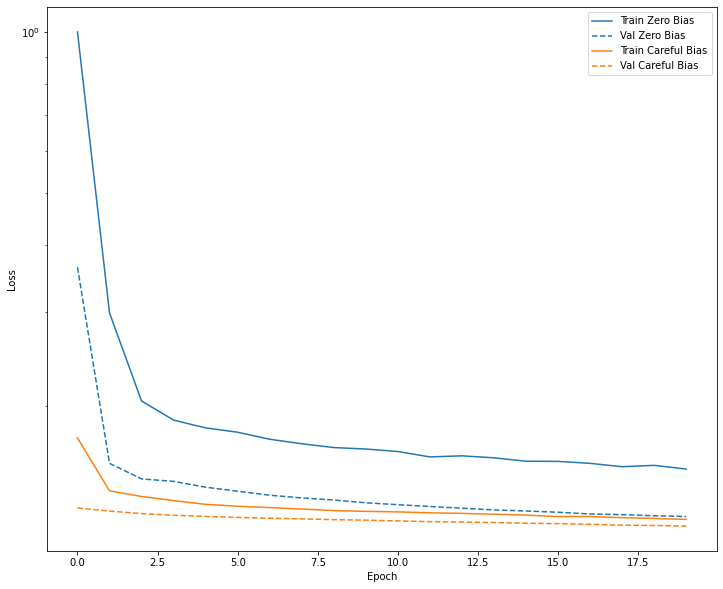

In [97]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

위의 그림은 이를 명확하게 보여줍니다. 유효성 검사 손실 측면에서 이 문제에 대해 조심스러운 초기화는 명확한 이점을 제공합니다. 

### **모델 훈련**

In [98]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
51/51 [==============================] - 1s 16ms/step - loss: 0.1736 - tp: 48.0000 - fp: 1006.0000 - tn: 123644.0000 - fn: 3651.0000 - accuracy: 0.9637 - precision: 0.0455 - recall: 0.0130 - auc: 0.5338 - val_loss: 0.1288 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 24948.0000 - val_fn: 722.0000 - val_accuracy: 0.9719 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5188
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 0.1391 - tp: 0.0000e+00 - fp: 1.0000 - tn: 99701.0000 - fn: 2977.0000 - accuracy: 0.9710 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5207 - val_loss: 0.1272 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 24948.0000 - val_fn: 722.0000 - val_accuracy: 0.9719 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5730
Epoch 3/100
51/51 [==============================] - 0s 6ms/step - loss: 0.1356 - tp: 1.0000 - fp: 1.0000 - tn: 99701.0000 - fn: 2976.0000 - accuracy: 0.9710 - precision: 0.5

### 학습 이력 확인
이 섹션에서는 훈련 및 검증 세트에 대한 모델의 정확도와 손실에 대한 plot을 생성합니다. 이는 과적합을 확인하는데 유용하며 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)에서 자세한 내용을 확인할 수 있습니다.

추가적으로, 위에서 만든 모든 메트릭에 대해 이러한 plot을 생성할 수 있습니다. 거짓 음성이 포함되는 경우가 예시입니다.

In [101]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.5,1])
        else:
            plt.ylim([0,1])

        plt.legend()


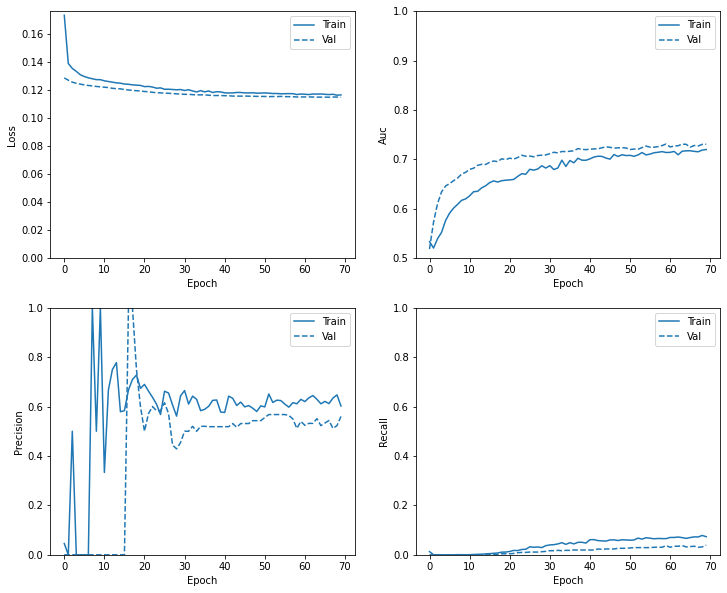

In [102]:
plot_metrics(baseline_history)

참고: 검증 곡선은 일반적으로 훈련 곡선보다 성능이 좋습니다. 이는 주로 모델을 평가할 때 drop out 레이어가 활성화 되지 않았기 때문에 발생합니다.

### 메트릭 평가

[혼동 행렬](https://developers.google.com/machine-learning/glossary/#confusion_matrix) 을 사용하여 X축이 예측 레이블이고 Y축이 실제 레이블인 실제 레이블과 예측 레이블을 요약할 수 있습니다.

In [103]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [104]:
print(train_predictions_baseline.shape)
train_predictions_baseline

(102679, 1)


array([[0.02344939],
       [0.00434873],
       [0.04316524],
       ...,
       [0.00236452],
       [0.02865157],
       [0.0246512 ]], dtype=float32)

In [105]:
print(test_predictions_baseline.shape)
test_predictions_baseline

(8200, 1)


array([[0.03765142],
       [0.03200525],
       [0.03235388],
       ...,
       [0.03872317],
       [0.02631113],
       [0.01446477]], dtype=float32)

In [107]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

테스트 데이터 세트에서 모델을 평가하고 위에서 만든 측정 항목의 결과를 표시합니다.

loss :  0.07216359674930573
tp :  3.0
fp :  11.0
tn :  8070.0
fn :  116.0
accuracy :  0.984512209892273
precision :  0.2142857164144516
recall :  0.02521008439362049
auc :  0.7678301930427551

Legitimate Transactions Detected (True Negatives):  8070
Legitimate Transactions Incorrectly Detected (False Positives):  11
Fraudulent Transactions Missed (False Negatives):  116
Fraudulent Transactions Detected (True Positives):  3
Total Fraudulent Transactions:  119


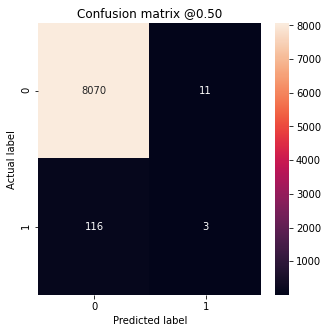

In [108]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

### ROC 플로팅

이제 [ROC](https://developers.google.com/machine-learning/glossary#ROC)을 플로팅 하십시오. 이 그래프는 출력 임계값을 조정하기만 해도 모델이 도달할 수 있는 성능 범위를 한눈에 보여주기 때문에 유용합니다.

In [113]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,40])
    plt.ylim([30,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

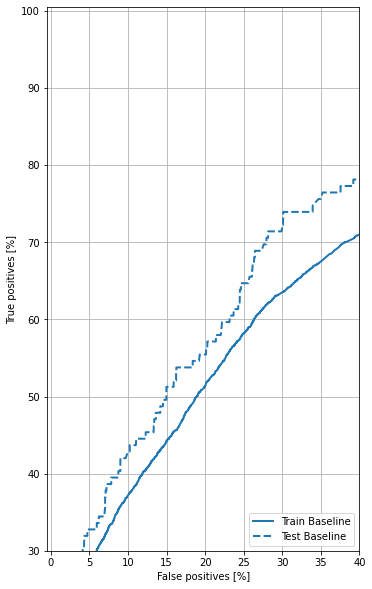

In [114]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

비교적 정밀도가 높은 것 같지만 회수율과 ROC 곡선(AUC) 밑 면적이 마음에 들 만큼 높지 않습니다. 분류자는 정밀도와 리콜을 모두 최대화 하려고 할 때 종종 도전해야 할 문제에 직면하는데, 이는 불균형 데이터세트로 작업할 떄 특히 그러합니다. 당신이 신경쓰는 문제의 맥락에서 다른 유형의 오류의 비용을 고려하는 것이 중요합니다. 이 예시에서 거짓음성(부정 거래를 놓친 경우)은 금전적인 비용을 초래하지만 , 거짓 양성(거래가 사기 행위로 잘못 표시됨)은 사용자들의 만족도를 감소시킬 수 있습니다. 

## 클래스 가중치

### 클래스 가중치 계산

목표는 부정 거래를 식별하는 것이지만, 여러분은 작업할 수 있는 긍정적인 샘플이 많지 않기 깨문에 분류자가 이용할 수 있는 몇 가지 예에 가중치를 두고자 할 것입니다. 매개 변수를 통해 각 클래스에 대한 Keras 가중치를 전달한다면 이 과정을 할 수 있습니다. 이로 인해 모델이 덜 표현된 클래스의 예에 "더 많은 주의를 기울이십시오"라고 할 수도 있습니다.

In [54]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### 클래스 가중치로 모델 교육

이제 해당 모델이 예측에 어떤 영향을 미치는지 확인하기 위하여 클래스 가중치로 모델을 재 교육하고 평가해 보십시오.

참고: `class_weights` 를 사용하면 손실 범위가 바뀝니다. 이는 최적기에 따라 학습의 안정성에 영향을 미칠 수 있습니다. 단계 크기가 그라데이션의 크기에 따라 달라지는 `optimizers.SGD` 와 같은 최적화 도구는 실패할 수 있습니다. 여기서 사용되는 최적화기인 `optimizers.Adam` 은 스케일링 변화에 영향을 받지 않습니다. 또한 가중치 때문에 전체 손실은 두 모델 간에 비교할 수 없습니다. 

In [55]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 1s 10ms/step - loss: 1.1010 - tp: 235.0000 - fp: 909.0000 - tn: 237920.0000 - fn: 174.0000 - accuracy: 0.9955 - precision: 0.2054 - recall: 0.5746 - auc: 0.8711 - val_loss: 0.0138 - val_tp: 60.0000 - val_fp: 79.0000 - val_tn: 45407.0000 - val_fn: 23.0000 - val_accuracy: 0.9978 - val_precision: 0.4317 - val_recall: 0.7229 - val_auc: 0.9255
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 0.5462 - tp: 202.0000 - fp: 1448.0000 - tn: 180535.0000 - fn: 91.0000 - accuracy: 0.9916 - precision: 0.1224 - recall: 0.6894 - auc: 0.9294 - val_loss: 0.0210 - val_tp: 64.0000 - val_fp: 147.0000 - val_tn: 45339.0000 - val_fn: 19.0000 - val_accuracy: 0.9964 - val_precision: 0.3033 - val_recall: 0.7711 - val_auc: 0.9375
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.4765 - tp: 223.0000 - fp: 2322.0000 - tn: 179661.0000 - fn: 70.0000 - accuracy: 0.9869 - precision: 0.0876 - recall: 0.7611 - auc: 0.9301

### 학습 이력 조회

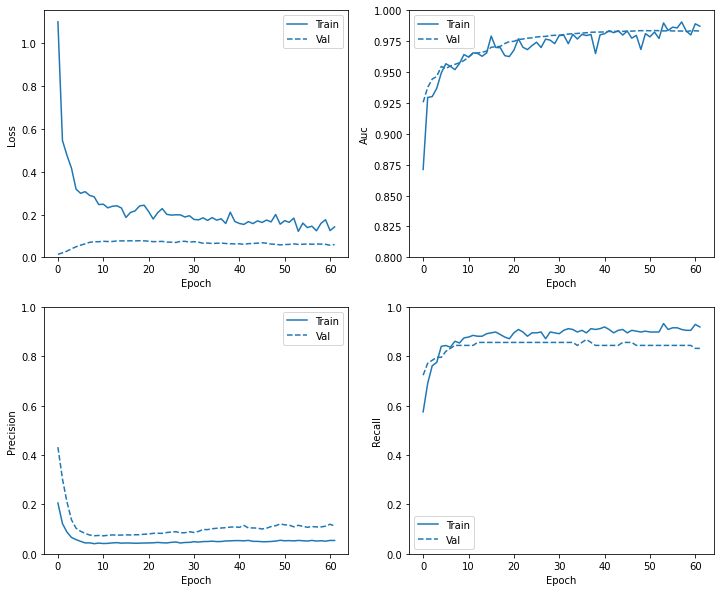

In [56]:
plot_metrics(weighted_history)

### 매트릭 평가

In [57]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.05782008543610573
tp :  104.0
fp :  657.0
tn :  56189.0
fn :  12.0
accuracy :  0.9882553219795227
precision :  0.1366622895002365
recall :  0.8965517282485962
auc :  0.988943338394165

Legitimate Transactions Detected (True Negatives):  56189
Legitimate Transactions Incorrectly Detected (False Positives):  657
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  104
Total Fraudulent Transactions:  116


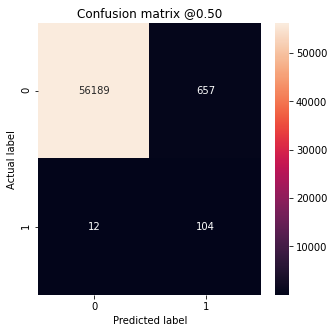

In [58]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

여기서 클래스 가중치를 사용하면 거짓 긍정이 더 많기 때문에 정확도와 정밀도가 낮다는 것을 알 수 있지만, 반대로 리콜과 AUC는 참 긍정이 더 많은 모델입니다. 정확도가 낮음에도 불구하고 이 모델은 리콜이 더 높습니다.(그리고 더 많은 부정 거래를 식별한다.) 물론 두 가지 유형의 오류에는 모두 비용이 발생합니다.(너무 많은 합법적인 거래를 사기로 표시하여 사용자를 괴롭히는 것을 원하지 않을 것입니다.) 응용 프로그램에 대하여 이러한 다양한 유형의 오류 간의 절충을 신중하게 고려하십시오.

### ROC 플로팅

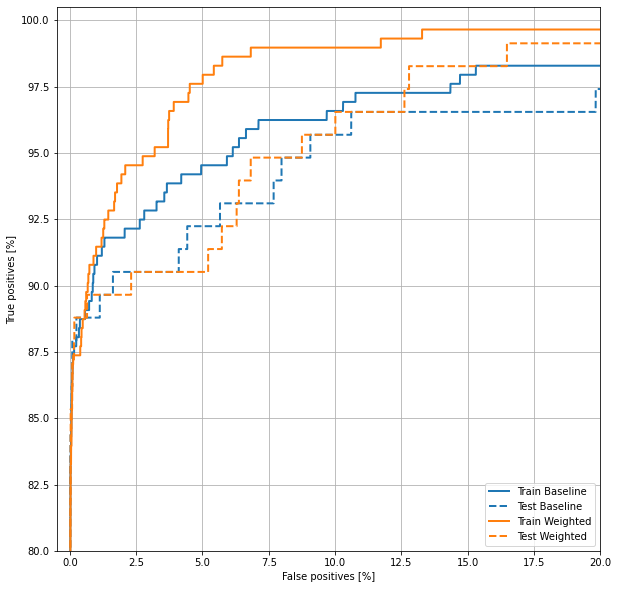

In [59]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## 오버샘플링

### 소수 계급 과대 표본

관련된 접근 방식은 소수 클래스를 오버 샘플링 하여 데이터 세트를 리 샘플링 하는 것입니다.

In [38]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### NumPy 사용

긍정적인 예에서 적절한 수의 임의 인덱스를 선택하여 데이터 세트의 균형을 
수동으로 조정할 수 있습니다.:

In [39]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181946, 29)

In [40]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363892, 29)

#### `tf.data` 사용

`tf.data` 사용하는 경우 균형 잡힌 예제를 생성하는 가장 쉬운 방법은 `positive` 그리고 `negative` 데이터 세트로 시작하여 병합하는 것입니다. 더 많은 예는 [tf.data guide](../../guide/data.ipynb) 를 참조하세요.

In [41]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

각 데이터 세트는 `(feature, label)` 쌍을 제공합니다.:

In [42]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-1.71716559  1.47005786 -2.47738985  0.19498166 -1.69346885 -1.480288
 -2.50054314 -1.41973413  0.16941577 -4.57371112  3.57266458 -5.
 -1.09645923 -5.          1.56465042 -5.         -5.         -3.35739236
  1.0754794  -0.04924097  2.86749363 -0.70728706 -0.40225951  0.21121368
  0.19880498 -2.18727931 -3.03575199 -3.05769118  0.75924124]

Label:  1


`experimental.sample_from_datasets` 를 사용하여 두 가지를 병합합니다.:

In [43]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [44]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.48779296875


이 데이터 세트를 사용하려면 epoch 당 단계 수가 필요합니다.

이 경우 "epoch" 의 정의는 명확하지 않습니다. 각 부정적인 예를 한번 볼 때 필요한 배치 수라고 가정합니다.:

In [45]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### 오버 샘플링 된 데이터에 대한 학습

이제 클래스 가중치를 사용하는 대신 리 샘플링 된 데이터 세트로 모델을 학습하여 이러한 방법이 어떻게 비교되는지 확인하십시오.

참고: 긍정적인 예를 복제하여 데이터가 균형을 이루었기 때문에 총 데이터 세트 크기가 더 크고 각 세대가 더 많은 학습 단계를 위해 실행됩니다. 

In [46]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 9s 26ms/step - loss: 0.5210 - tp: 121561.5054 - fp: 41117.0430 - tn: 158732.2222 - fn: 22263.8889 - accuracy: 0.8122 - precision: 0.7057 - recall: 0.8153 - auc: 0.9032 - val_loss: 0.2060 - val_tp: 66.0000 - val_fp: 865.0000 - val_tn: 44629.0000 - val_fn: 9.0000 - val_accuracy: 0.9808 - val_precision: 0.0709 - val_recall: 0.8800 - val_auc: 0.9745
Epoch 2/100
278/278 [==============================] - 7s 24ms/step - loss: 0.1969 - tp: 130064.3047 - fp: 5756.9534 - tn: 137217.6487 - fn: 13673.7527 - accuracy: 0.9305 - precision: 0.9550 - recall: 0.9039 - auc: 0.9736 - val_loss: 0.1000 - val_tp: 66.0000 - val_fp: 703.0000 - val_tn: 44791.0000 - val_fn: 9.0000 - val_accuracy: 0.9844 - val_precision: 0.0858 - val_recall: 0.8800 - val_auc: 0.9791
Epoch 3/100
278/278 [==============================] - 7s 25ms/step - loss: 0.1445 - tp: 131797.2867 - fp: 4093.8889 - tn: 139202.3082 - fn: 11619.1756 - accuracy: 0.9443 - precision: 0.9697 - re

만약 훈련 프로세스가 각 기울기 업데이트에서 전체 데이터 세트를 고려하는 경우, 이 오버 샘플링은 기본적으로 클래스 가중치와 동일합니다. 

그러나 여기에서 한 것처럼 모델을 배치 방식으로 훈련 할 때 오버 샘플링 된 데이터는 더 부드러운 기울기 신호를 제공합니다. 각각의 긍정적인 예가 큰 가중치를 가진 하나의 배치로 표시되는 대신, 그것들은 작은 가중치로 매 회 많은 다른 배치로 보여집니다. 

이 부드러운 기울기 신호는 모델을 더 쉽게 훈련 할 수 있습니다.

### 교육 이력 확인

학습 데이터의 분포가 검증 및 테스트 데이터와 완전히 다르기 때문에 여기서 측정 항목의 분포가 다를 수 있습니다. 

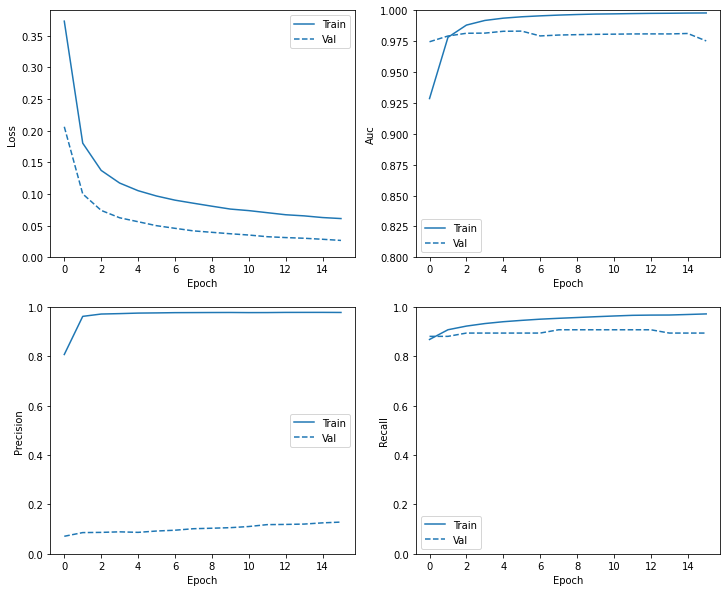

In [47]:
plot_metrics(resampled_history)

### 재교육


균형 잡힌 데이터에 대한 훈련이 더 쉽기 때문에 위의 훈련 절차가 빠르게 과적합 될 수 있습니다. 

따라서 epochs를 분리하여 `callbacks.EarlyStopping`을 제공하십시오. 

In [48]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 3s 64ms/step - loss: 0.8553 - tp: 7544.1429 - fp: 5543.8095 - tn: 51153.8571 - fn: 3757.6667 - accuracy: 0.8716 - precision: 0.5583 - recall: 0.6545 - auc: 0.9162 - val_loss: 0.6783 - val_tp: 70.0000 - val_fp: 18281.0000 - val_tn: 27213.0000 - val_fn: 5.0000 - val_accuracy: 0.5987 - val_precision: 0.0038 - val_recall: 0.9333 - val_auc: 0.9343
Epoch 2/1000
20/20 [==============================] - 1s 29ms/step - loss: 0.5958 - tp: 8912.1905 - fp: 4871.4762 - tn: 6467.1905 - fn: 2179.6190 - accuracy: 0.6800 - precision: 0.6406 - recall: 0.7979 - auc: 0.8074 - val_loss: 0.6313 - val_tp: 71.0000 - val_fp: 15726.0000 - val_tn: 29768.0000 - val_fn: 4.0000 - val_accuracy: 0.6548 - val_precision: 0.0045 - val_recall: 0.9467 - val_auc: 0.9452
Epoch 3/1000
20/20 [==============================] - 1s 30ms/step - loss: 0.5067 - tp: 9444.6667 - fp: 4316.9524 - tn: 6978.1905 - fn: 1690.6667 - accuracy: 0.7280 - precision: 0.6817 - recall: 0.8441 -

### 훈련 이력 재확인

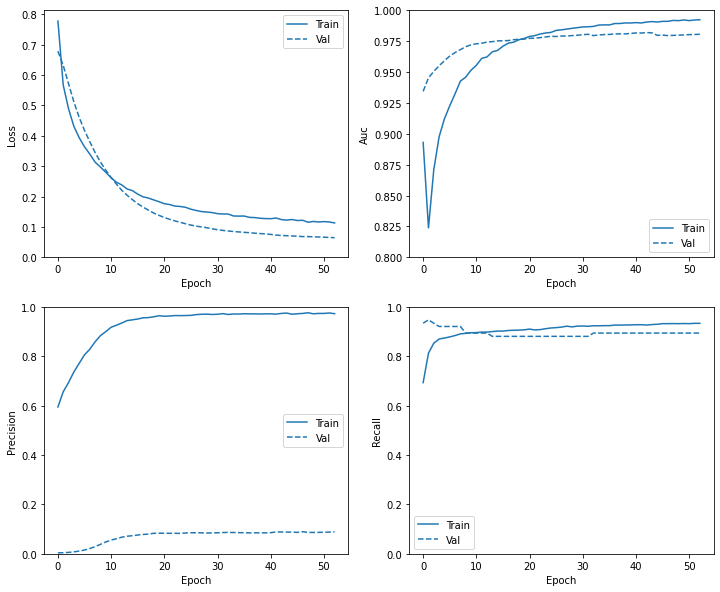

In [49]:
plot_metrics(resampled_history)

### 메트릭 평가

In [50]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0707845687866211
tp :  74.0
fp :  828.0
tn :  56047.0
fn :  13.0
accuracy :  0.9852357506752014
precision :  0.08203991502523422
recall :  0.8505747318267822
auc :  0.944765031337738

Legitimate Transactions Detected (True Negatives):  56047
Legitimate Transactions Incorrectly Detected (False Positives):  828
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  74
Total Fraudulent Transactions:  87


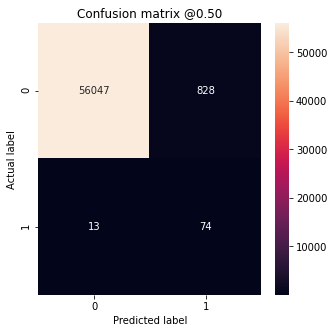

In [51]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### ROC 플로팅

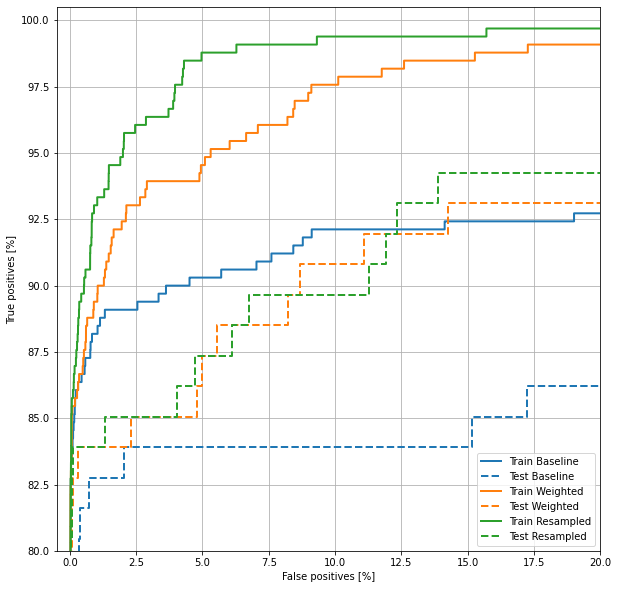

In [52]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')